In [1]:
# Map of observations during Helene
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cf
import geopandas as gpd
import numpy as np

In [2]:
# Define some colors
noaa_blue = '#1D70B7'
usgs_green = '#2E8B57'

In [3]:
df = pd.read_csv('water_level_sites.csv')
noaa_df = df[df['type'] == 'NOAA tide gauge']
rdg_df = df[df['type'] == 'USGS rapid deployment gauge']
st_df = df[df['type'] == 'USGS pressure sensor']

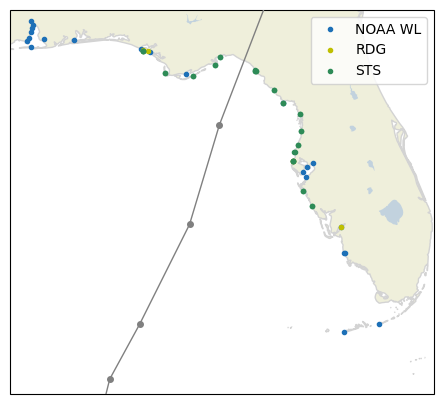

In [4]:
cpc = crs.PlateCarree()

fig1 = plt.figure()
ax1 = fig1.add_axes((0.12, 0.125, 0.8, 0.8),projection=cpc)
ax1.set_extent([-88.5, -80, 23.3, 31])
ax1.add_feature(cf.LAND, edgecolor='lightgray', linewidth=1, zorder=-1)
#ax1.add_feature(cf.COASTLINE)
ax1.add_feature(cf.LAKES, alpha=0.5)

## That sets up the plot.  To plot something, I'll just open the shapefile with the nhc best track

gd1 = gpd.read_file('AL092024_pts.shp')
lt1 = gd1.LAT
ln1 = gd1.LON
hurpth = np.array(list(zip(ln1,lt1)))

ax1.plot(hurpth[:,0],hurpth[:,1],'o-', markersize=4, linewidth=1, c='gray', zorder=5)
ax1.plot(noaa_df['longitude'],noaa_df['latitude'],'.',color=noaa_blue, label='NOAA WL')
ax1.plot(rdg_df['longitude'],rdg_df['latitude'],'.y',label='RDG')
ax1.plot(st_df['longitude'],st_df['latitude'],'.',c=usgs_green,label='STS')
ax1.legend()

In [5]:
gd1

,STORMNAME,DTG,YEAR,MONTH,DAY,HHMM,MSLP,BASIN,STORMNUM,STORMTYPE,INTENSITY,SS,LAT,LON,geometry
0,HELENE,2.024092e+09,2024.0,09,24.0,1200,1000.0,al,9.0,TS,40.0,0.0,19.2,-83.6,POINT (-83.6 19.2)
1,HELENE,2.024092e+09,2024.0,09,24.0,1800,997.0,al,9.0,TS,45.0,0.0,19.4,-84.6,POINT (-84.6 19.4)
2,HELENE,2.024092e+09,2024.0,09,25.0,0000,991.0,al,9.0,TS,50.0,0.0,19.7,-85.2,POINT (-85.2 19.7)
3,HELENE,2.024093e+09,2024.0,09,25.0,0600,986.0,al,9.0,TS,55.0,0.0,20.3,-85.9,POINT (-85.9 20.3)
4,HELENE,2.024093e+09,2024.0,09,25.0,1200,979.0,al,9.0,HU,65.0,1.0,21.1,-86.2,POINT (-86.2 21.1)
5,HELENE,2.024093e+09,2024.0,09,25.0,1800,978.0,al,9.0,HU,75.0,1.0,22.0,-86.6,POINT (-86.6 22)
6,HELENE,2.024093e+09,2024.0,09,26.0,0000,973.0,al,9.0,HU,75.0,1.0,22.8,-86.7,POINT (-86.7 22.8)
7,HELENE,2.024093e+09,2024.0,09,26.0,0600,970.0,al,9.0,HU,75.0,1.0,23.6,-86.5,POINT (-86.5 23.6)
8,HELENE,2.024093e+09,2024.0,09,26.0,1200,960.0,al,9.0,HU,85.0,2.0,24.7,-85.9,POINT (-85.9 24.7)
9,HELENE,2.024093e+09,2024.0,09,26.0,1800,958.0,al,9.0,HU,105.0,3.0,26.7,-84.9,POINT (-84.9 26.7)
